In [1]:
!pip install hmmlearn

In [2]:
!pip install statsmodels

In [3]:
!pip install deeptime

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [4]:
!pip install pydmd

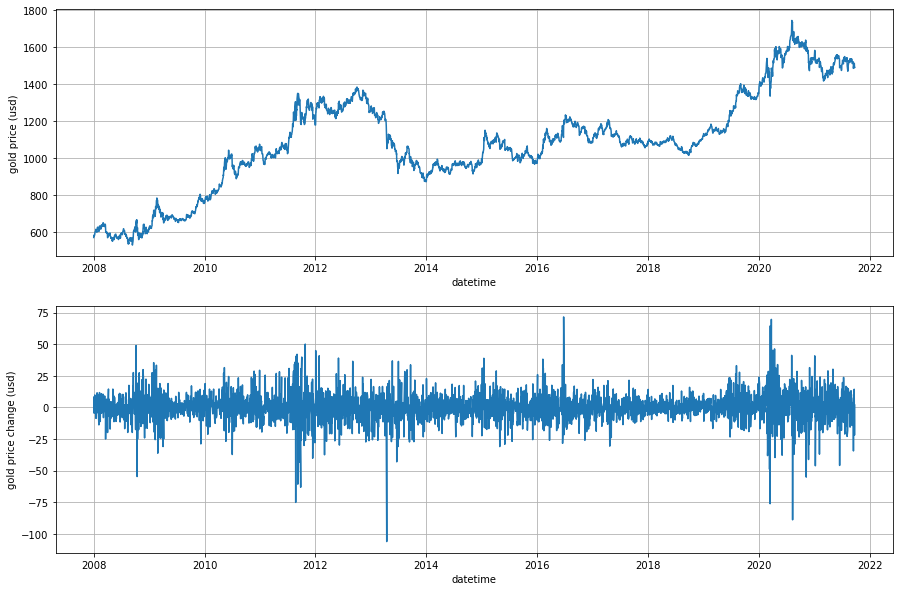

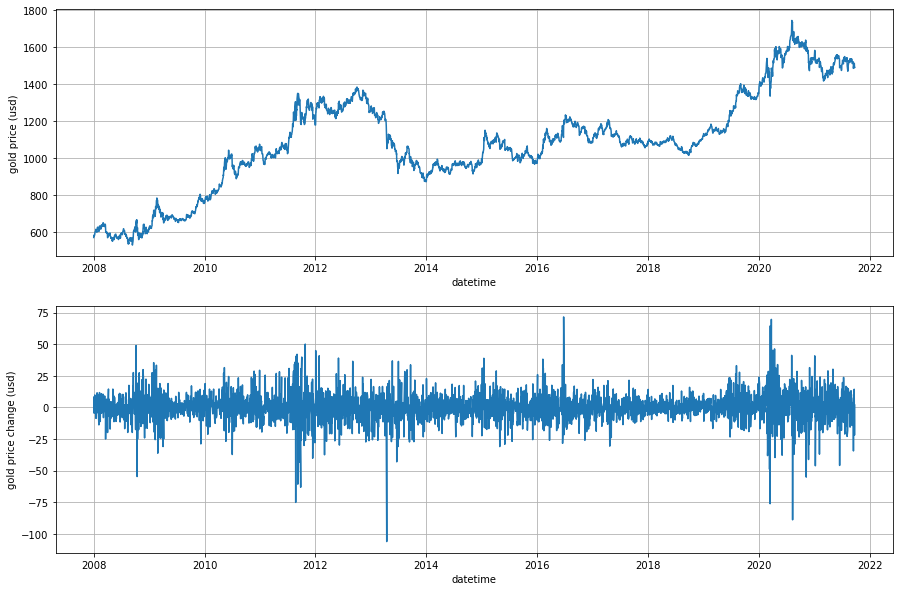

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

base_dir = "gold_price_usd.csv"

data = pd.read_csv(base_dir)

# Convert the datetime from str to datetime object.
data["datetime"] = pd.to_datetime(data["datetime"])

# Determine the daily change in gold price.
data["gold_price_change"] = data["gold_price_usd"].diff()

# Restrict the data to later than 2008 Jan 01.
data = data[data["datetime"] >= pd.to_datetime("2008-01-01")]

# Plot the daily gold prices as well as the daily change.
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["datetime"], data["gold_price_usd"])
plt.xlabel("datetime")
plt.ylabel("gold price (usd)")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data["datetime"], data["gold_price_change"])
plt.xlabel("datetime")
plt.ylabel("gold price change (usd)")
plt.grid(True)
plt.show()
data = pd.read_csv(base_dir)

# Convert the datetime from str to datetime object.
data["datetime"] = pd.to_datetime(data["datetime"])

# Determine the daily change in gold price.
data["gold_price_change"] = data["gold_price_usd"].diff()

# Restrict the data to later than 2008 Jan 01.
data = data[data["datetime"] >= pd.to_datetime("2008-01-01")]

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["datetime"], data["gold_price_usd"])
plt.xlabel("datetime")
plt.ylabel("gold price (usd)")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data["datetime"], data["gold_price_change"])
plt.xlabel("datetime")
plt.ylabel("gold price change (usd)")
plt.grid(True)
plt.show()

# Basic Analysis

In [8]:
d = data[["datetime","gold_price_usd"]].reset_index(drop=True)
d.set_index(["datetime"],inplace=True)
d.head()

,gold_price_usd
datetime,
2008-01-01,570.26
2008-01-02,575.02
2008-01-03,583.36
2008-01-04,578.70
2008-01-07,583.83


Rolling

Text(0.5, 1.0, 'Rolling Standard Deviation')

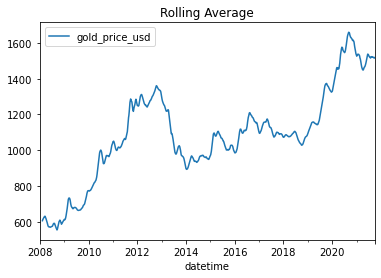

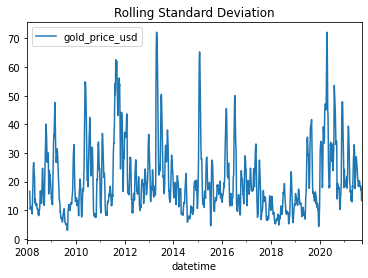

In [9]:
rolling = d.rolling(window=30) #monthwise
rolling_mean  = rolling.mean()
rolling_var = rolling.std()

rolling_mean.plot()

plt.title("Rolling Average")

#From the plot we can see that the signal is highly non-stationary
#Mean is not constant, hence not stationary

rolling_var.plot()
plt.title("Rolling Standard Deviation")

ExponentialSmoothing

Exponential smoothing is a rule of thumb technique for smoothing time series data using the exponential window function

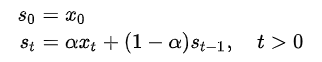

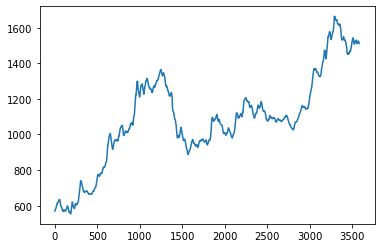

In [20]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing

fit1 = SimpleExpSmoothing(d.to_numpy()).fit(smoothing_level=0.1,optimized=False)
plt.plot(fit1.fittedvalues)

In [21]:
d.values
#represents time series

array([[ 570.26],
       [ 575.02],
       [ 583.36],
       ...,
       [1511.4 ],
       [1489.43],
       [1491.27]])

#AD-Fuller Test: Augmented Dickey-Fuller (ADF) test is a statistical test used for testing the null hypothesis that a time series is non-stationary. 


In [18]:
#Null Hypothisis: Series is non-stationary. if pvalue<5% reject null
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(d.values,autolag="AIC")
# AIC (Akaike Information Criteria) is a statistical measure that assesses the quality of a 
# model relative to other models. 

print(f"ADF Statistic: {adfuller_test[0]}")
print(f"p-value: {adfuller_test[1]}")

for key,values in adfuller_test[4].items():
    print("Critical Values:")
    print(f"{key}: {values}")

ADF Statistic: -1.4061859628978646
p-value: 0.5793069233440593
Critical Values:
1%: -3.4321820284304763
Critical Values:
5%: -2.862349487253214
Critical Values:
10%: -2.5672009032458503


p value is >5% we cannot reject the null hypothesis. The series is hence stationary

# Decomposition

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
d = data[["datetime","gold_price_usd"]].reset_index(drop=True)
d.set_index(["datetime"],inplace=True)


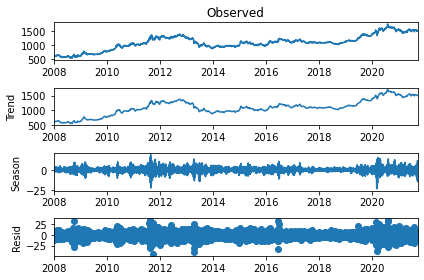

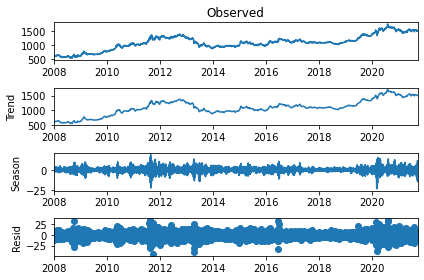

In [23]:
#Seasonal-Trend Decomposition

from statsmodels.tsa.seasonal import STL,seasonal_decompose

stl = STL(d)
result = stl.fit()

seasonal,trend,resid = result.seasonal,result.trend, result.resid
result.plot()


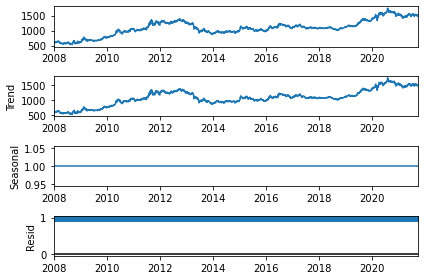

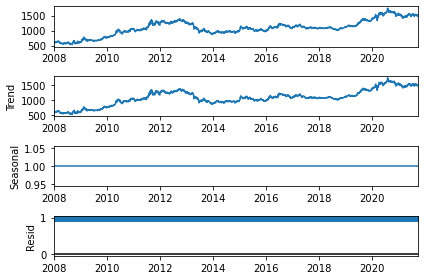

In [24]:
m = seasonal_decompose(d,model="multiplicative",period=1)

m.plot()

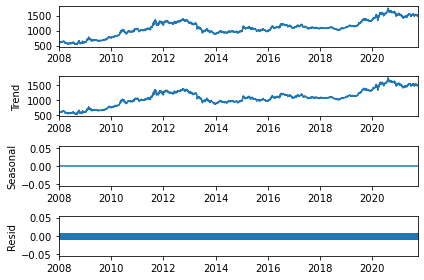

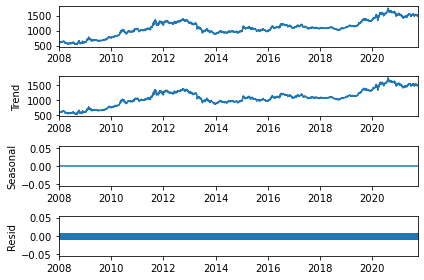

In [25]:
a = seasonal_decompose(d,model="additive",period=1)

a.plot()

Trend Component is high

## Anomaly Detection

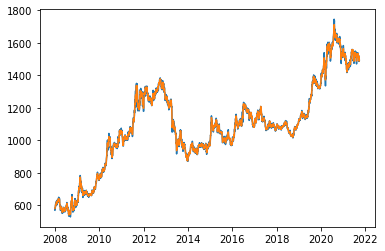

In [26]:
plt.plot(d)
plt.plot(trend+seasonal)

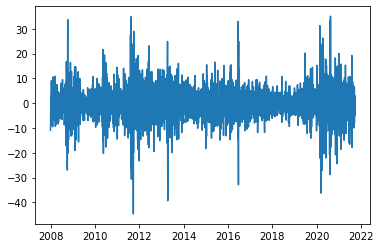

In [27]:
plt.plot(resid)

Mean: -0.006425356153771425, std: 6.436175884921611


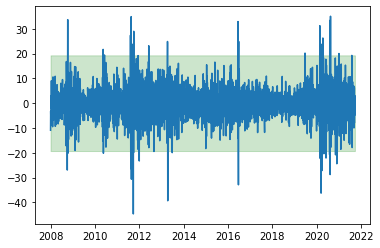

In [28]:
#we say an anomoly has occured if the residual lies outside of mu+/-3*sigma range
resid_mu = resid.mean()
resid_std = resid.std()
print(f"Mean: {resid_mu}, std: {resid_std}")

lower_limit = resid_mu - 3*resid_std
upper_limit = resid_mu + 3*resid_std

plt.fill_between(d.index,lower_limit,upper_limit,color="green",alpha=0.2)
plt.plot(resid)

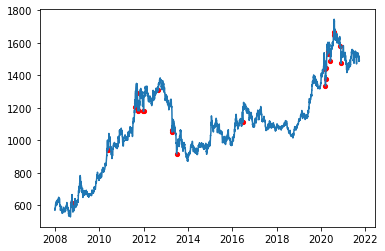

In [29]:
an = d[( (resid<lower_limit)  * (resid<upper_limit) )]
plt.plot(d)
plt.scatter(an.index, an.values,marker='.',s=70,c='r')

In [30]:
#Anomalies 
an

,gold_price_usd
datetime,
2008-10-03,599.67
2008-10-13,612.00
2010-05-21,939.52
2011-08-15,1203.84
2011-08-25,1204.71
2011-08-29,1230.13
2011-09-07,1289.54
2011-09-26,1186.21
2011-09-29,1181.82


# Advanced Decomposition Algorithms:

we try some advanced decomposition algorithms

In [31]:
from deeptime.data import ellipsoids

h = ellipsoids(seed=17)
#ellipsoid can be used as a model for the covariance matrix of a multivariate normal distribution. 
discrete_trajectory = h.discrete_trajectory(n_steps=1000)
feature_trajectory = h.map_discrete_to_observations(discrete_trajectory)

PCA (Principal Component Analysis) is likely used as a dimensionality reduction technique for time series data.

VAMP is a nonlinear method that seeks to identify the slow processes underlying a molecular dynamics trajectory by mapping the high-dimensional data onto a low-dimensional space that captures the underlying slow modes

TICA is a linear method that transforms the original time series data into a new coordinate system with lower dimensions by finding a set of linearly uncorrelated components that capture the most significant fluctuations in the data.

C:\Users\laksh\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


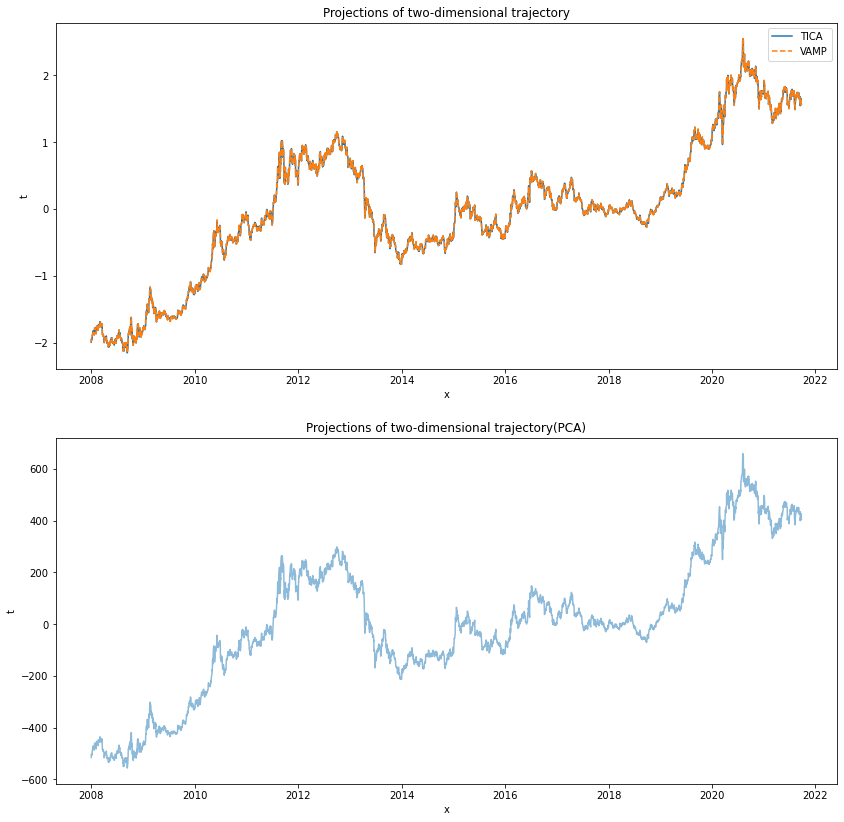

In [32]:
from sklearn.decomposition import PCA
from deeptime.decomposition import VAMP, TICA
#PCA (Principal Component Analysis) is likely used as a dimensionality reduction technique for time series data
pca = PCA(n_components=1)
pca.fit(d.to_numpy())
pca_projection = pca.transform(d)
dxy_pca = pca.components_[0]  # dominant pca component
#VAMP is a nonlinear method that seeks to identify the slow processes underlying a molecular dynamics 
vamp = VAMP(dim=1, lagtime=1)
vamp = vamp.fit(d.to_numpy()).fetch_model()
vamp_projection = vamp.transform(d)
dxy_vamp = vamp.singular_vectors_left[:, 0]  # dominant vamp component
#TICA is a linear method that transforms the original time series data into a new coordinate system
tica = TICA(dim=1, lagtime=1)
tica = tica.fit(d.to_numpy()).fetch_model()
tica_projection = tica.transform(d)
dxy_tica = tica.singular_vectors_left[:, 0]  # dominant tica component


f = plt.figure(constrained_layout=False, figsize=(14, 14))
gs = f.add_gridspec(nrows=2, ncols=3)
ax_projections = f.add_subplot(gs[0, :])
ax_projections_ = f.add_subplot(gs[1, :])

ax_projections.set_title("Projections of two-dimensional trajectory")
ax_projections.set_xlabel('x')
ax_projections.set_ylabel('t')

ax_projections_.set_title("Projections of two-dimensional trajectory(PCA)")
ax_projections_.set_xlabel('x')
ax_projections_.set_ylabel('t')


ax_projections_.plot(d.index, pca_projection, label='PCA', alpha=.5)
ax_projections.plot(tica_projection, label='TICA')
ax_projections.plot(vamp_projection, label='VAMP', linestyle='dashed')
ax_projections.legend()




In [34]:
# Use the daily change in gold price as the observed measurements X.
X = data[["gold_price_change"]].values
# Build the HMM model and fit to the gold price change data.
model = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 50, random_state = 42)
model.fit(X)
# Predict the hidden states corresponding to observed X.
Z = model.predict(X)
states = pd.unique(Z)

C:\Users\laksh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
print("Unique states:")
print(states)


Unique states:
[1 0 2]


In [36]:
print("\nStart probabilities:")
print(model.startprob_)


Start probabilities:
[9.00876474e-03 9.90991235e-01 1.90652535e-52]


In [37]:
print("\nTransition matrix:")
print(model.transmat_)


Transition matrix:
[[4.71987506e-02 9.52205396e-01 5.95853639e-04]
 [8.12868067e-01 1.35345228e-01 5.17867054e-02]
 [3.95757463e-02 4.27802116e-02 9.17644042e-01]]


In [38]:
print("\nGaussian distribution covariances:")
print(model.covars_)


Gaussian distribution covariances:
[[[ 28.11246244]]

 [[ 77.18151421]]

 [[324.43713708]]]


In [39]:
states

array([1, 0, 2], dtype=int64)

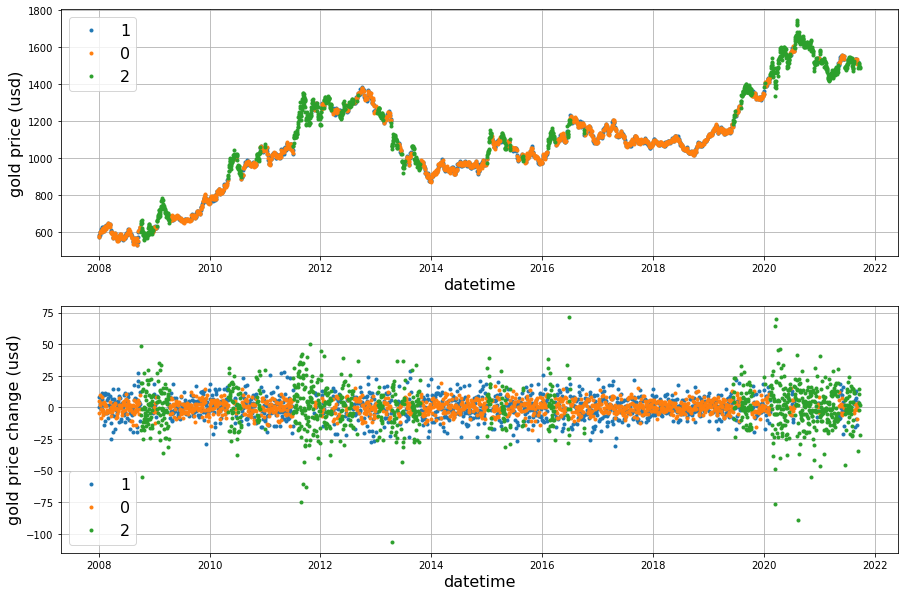

In [40]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_usd"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_change"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.show()

# DTW + Clustering

In [48]:
!pip install tslearn

In [49]:
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

from tslearn.clustering import TimeSeriesKMeans

from tslearn.preprocessing import TimeSeriesScalerMeanVariance


In [50]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    km = km.fit(strips)
    Sum_of_squared_distances.append(km.inertia_)

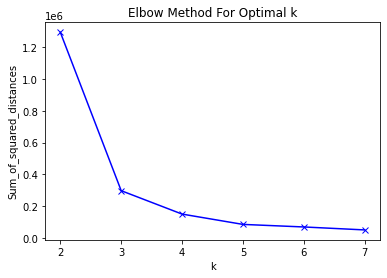

In [51]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From Elbow Method we can see that the curve has a "elbow" at k=3. Let us try k=3,4,5

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X_train=strips
train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_pca)

X = train_pca

range_n_clusters = [ 3, 4, 5]

The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters

C:\Users\laksh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\laksh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.62


C:\Users\laksh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\laksh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.56


C:\Users\laksh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\laksh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.54


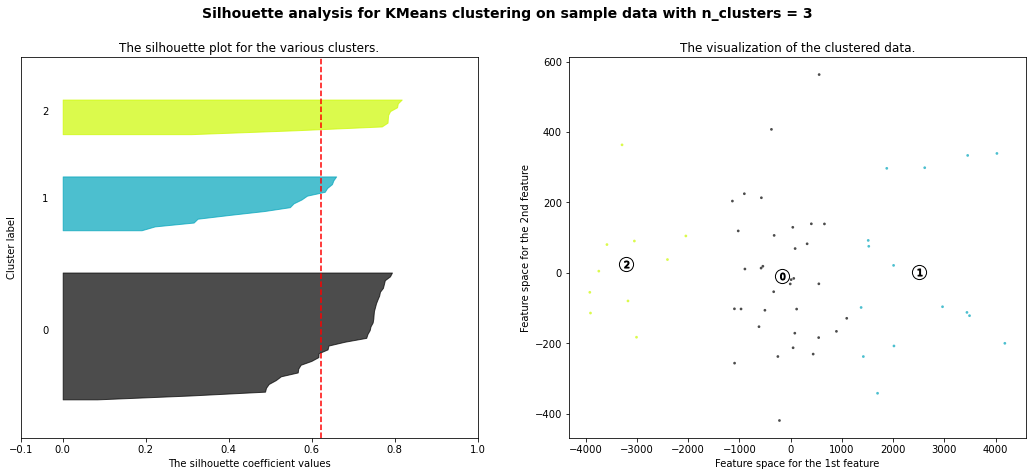

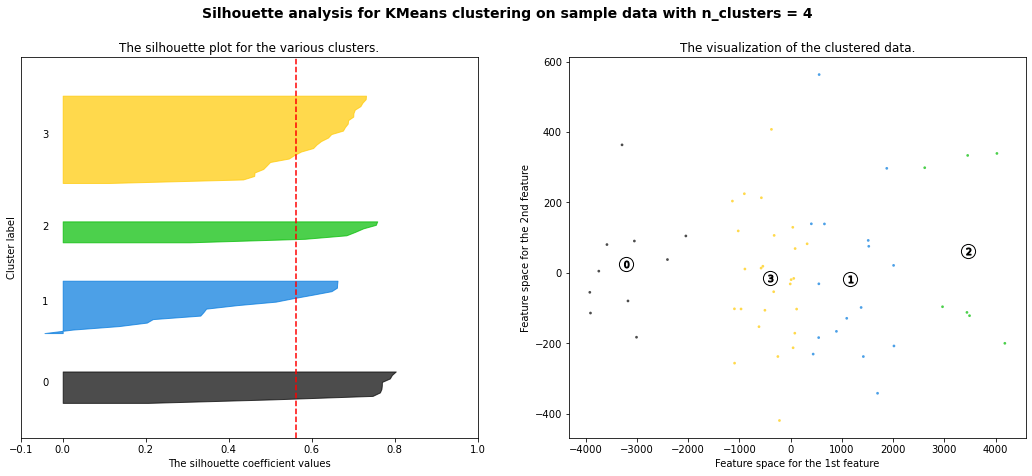

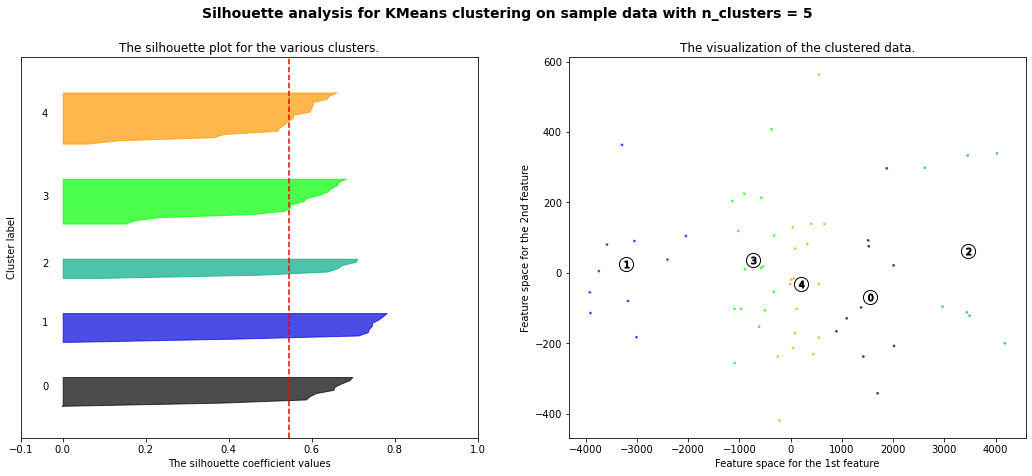

In [53]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


k=3 has the maximum silhoutte coefficient values and seems more naturally clustered. Let us fix k to be 3.Now let us train KMeans using Dynamic Time Wrapping



Dynamic Time Warping (DTW) is used to collect time series of similar shapes.(i.e cluster centroids, barycenters, are computed with respect to DTW)

In [55]:
n_clusters = 3
sz = X_train.shape[1]
seed = 0

dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

DBA silhoutte: 0.37


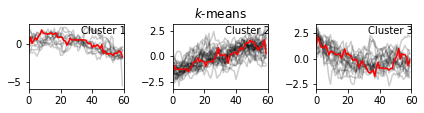

In [56]:
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
  
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("$k$-means")
        


plt.tight_layout()
plt.show()
#red line represents cluster Centre 
#if we scaled the time series bringing to 0 or 1 then it will be clustred more well 
#there will be no amplitude differences
#most occured trend in our signal 


As we can see we had clustered it pretty well. If we used some scaling functiosn, then clustering would be more eivdent

DBA silhoutte: 0.37


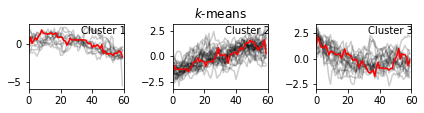

In [57]:
seed = 0
np.random.seed(seed)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
  
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("$k$-means")
        


plt.tight_layout()
plt.show()
